### **Study area visuallization.**
### 1) Spatial loaction of tibetan region 
### 2) Spatial distribution of dset (training and validation data, respectively.).

In [1]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings("ignore")
from notebooks import config
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from utils.transform_xy import coor2coor
from shapely.geometry import Polygon
import numpy as np
import pandas as pd
import geopandas as gpd
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from matplotlib.colors import LinearSegmentedColormap
from utils.raster_vec import vec2mask
import glob
import gc


### Extract scenes footprint from .tif images in dataset.

In [2]:
paths_truth = glob.glob(config.root_proj+'/data/dset/s1_truth/*truth.tif')
paths_truth = sorted(paths_truth)
names_truth = [os.path.basename(path) for path in paths_truth]
scene_id = [name[0:7] for name in names_truth]  # get scenes id
scene_id[0]


'scene01'

### Extract scene footprints from the dset.

In [3]:
# fprint_wgs84 = []
# center_wgs84 = []
# for path in paths_truth:
#     img, img_info = readTiff(path)
#     lon_1, lon_2, lat_1, lat_2 = img_info['geoextent']
#     lon = [lon_1, lon_2, lon_2, lon_1, lon_1]
#     lat = [lat_1, lat_1, lat_2, lat_2, lat_1]
#     lon_wgs84, lat_wgs84 = coor2coor(srs_from=img_info['geosrs'], srs_to=4326, x=lon, y=lat)
#     fprint = Polygon(zip(lon_wgs84, lat_wgs84))
#     fprint_wgs84.append(fprint)

# print('number of footprints:',len(fprint_wgs84))


number of footprints: 39


In [4]:
# # writh the data information to geopandas
# dic = {'scene_id': scene_id}
# df = pd.DataFrame(dic)
# fp_geodf = gpd.GeoDataFrame(df, geometry=fprint_wgs84, crs=4326)
# print(fp_geodf.head())
# fp_geodf.to_file(config.root_proj+'/data/dset/loc_vec/scene_footprint.shp')   ## save the footprint file


  scene_id                                           geometry
0  scene01  POLYGON ((82.25568 33.84709, 82.64803 33.84246...
1  scene02  POLYGON ((97.93004 34.61704, 98.35243 34.62001...
2  scene03  POLYGON ((90.61015 28.83351, 91.01593 28.84009...
3  scene04  POLYGON ((86.67000 35.47958, 87.09000 35.48000...
4  scene05  POLYGON ((89.78144 33.82872, 90.12918 33.82038...


### Load the prepared data

In [5]:
path_dset_fprint =  config.root_proj + '/data/dset/loc_vec/scene_footprint.shp'
path_tibet_boundry =  config.root_proj + '/data/tibet/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'
path_tibet_dem =  config.root_proj + '/data/tibet/dem/tibet_SRTMGL3_900m.tif'
path_water_jrc = config.root_proj + '/data/tibet/jrc_water/tibet_water_jrc_500m.tif'



In [6]:
## For non-tibet region mask
mask_tibet = vec2mask(path_vec=path_tibet_boundry, path_raster=path_tibet_dem, path_save=None)
mask_tibet.shape


(2280, 4560)

In [7]:
water_jrc, water_jrc_info= readTiff(path_water_jrc)
tibet_dem, tibet_dem_info = readTiff(path_tibet_dem)
tibet_dem_masked = np.ma.masked_where(mask_tibet == 0, tibet_dem).astype(np.float16).filled(np.nan)
water_jrc_masked = np.ma.masked_where(water_jrc == 0, water_jrc).astype(np.float16).filled(np.nan)
print(tibet_dem_info['geoextent'])
print(water_jrc_info['geoextent'])
print('dem shape: ', tibet_dem.shape)
print('water map shape: ', water_jrc_masked.shape)


(69.99958333327652, 107.99958333326788, 23.000416666675076, 42.00041666667076)
(73.4955751387102, 104.42457037094532, 25.991405273072196, 39.991648976074934)
dem shape:  (2280, 4560)
water map shape:  (3117, 6886)


### Extract scenes center coordinates of dataset

In [8]:
geodf_fp = gpd.read_file(path_dset_fprint)
coord_centers = []
for fprint in geodf_fp['geometry']:
    coord_centers += list(fprint.centroid.coords)
coord_centers = np.array(coord_centers)
coord_centers.shape
# coord_centers


(39, 2)

### Visuallization for study area and dset

In [13]:
# cmap_dem = LinearSegmentedColormap.from_list('linear color', ["black", "white"])
cmap_dem = LinearSegmentedColormap.from_list('linear color', ["DimGray", "white"])
cmap_water = LinearSegmentedColormap.from_list('linear color', ["lightBlue", 'Blue'])



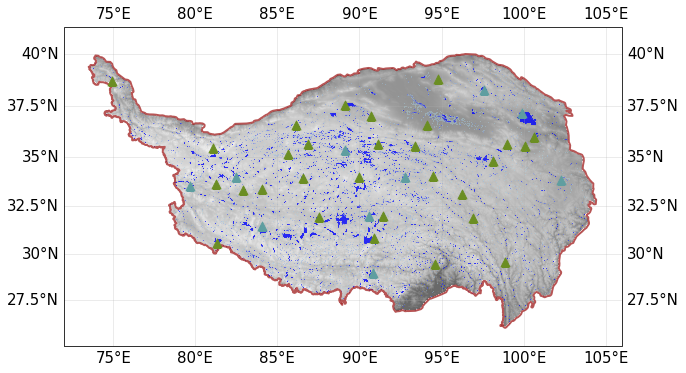

In [17]:
plt.rcParams.update({'font.size': 15})
alpha_water = np.clip((water_jrc/100.0), 0.4, 0.8) [::-1, :]  ## !!!flip from y-axis
coord_centers_tra = coord_centers[config.tra_ids]
coord_centers_val = coord_centers[config.val_ids]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([72, 106, 25.0, 40.0])
# 1. tibet boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_boundry).geometries(), \
                                crs=ccrs.PlateCarree(), edgecolor='Brown', alpha=0.8, \
                                linestyle='-', linewidth=2, facecolor='none')
ax.add_feature(shp_fea, zorder=2)

## 2. dem image
ax_dem = ax.imshow(tibet_dem_masked, extent=tibet_dem_info['geoextent'], 
                                vmin=1000, vmax=7000, cmap=cmap_dem, \
                                transform=ccrs.PlateCarree(), zorder=1)  # cmap:PRGn
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)

# ## 3. water map
ax_water = ax.imshow(water_jrc_masked, extent=water_jrc_info['geoextent'], \
                                vmin=1, vmax=100, alpha=alpha_water, interpolation='none', \
                                cmap=cmap_water, transform=ccrs.PlateCarree(), zorder=1)

## 4. scene samples
ax.scatter(coord_centers_tra[:,0], coord_centers_tra[:,1], color='OliveDrab', \
                                marker='^', s=80, alpha=1, transform=ccrs.PlateCarree(), zorder=2)
ax.scatter(coord_centers_val[:,0], coord_centers_val[:,1], color='CadetBlue', \
                                marker='^', s=80, alpha=1, transform=ccrs.PlateCarree(), zorder=2)

# plt.colorbar(ax_dem, fraction=0.025, pad=0.15, label='Elevation (m)')  #
# plt.colorbar(ax_water, fraction=0.025, pad=0.15, label='Water occurrence')   #
# plt.savefig(config.root_proj + '/figure/study_area.png', bbox_inches='tight')




### Sub-figure for study area

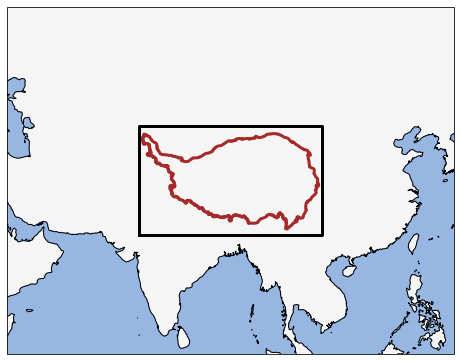

In [18]:
region_x = [73, 105, 105, 73, 73]
region_y = [25, 25, 41, 41, 25]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
# ax.stock_img()
ax.add_feature(cfeature.LAND, facecolor='WhiteSmoke')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE, edgecolor='Black')
ax.set_extent([50, 128, 5, 48.0])
# ax.gridlines(draw_labels=True,linewidth=0)
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_boundry).geometries(), \
                                crs=ccrs.PlateCarree(), linewidth=3, edgecolor='Brown', facecolor='none')
ax.add_feature(shp_fea, zorder=1)
# ax.gridlines(draw_labels=False)
plt.plot(region_x, region_y, transform=ccrs.PlateCarree(), linewidth=3, color='black')
